## Importing needed packages

In [52]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from scipy.stats import norm
from DataHandling import *
from ModelClasses import *
import matplotlib.pyplot as plt

## Defining Input Parameters

In [53]:
# Define number of hours as length of demand
N_Hours = hours_per_year

# Define number of generators as length of CapCost
N_Cap = len(CapCost)

# Define number of storage as length of StorCost
N_Stor = len(StorCost)

# Define number of scenarios as number of columns in ProdFacWind
N_Scen = scenarios_per_year * len(years)

# Define epsilon
epsilon = 0

#Define delta
delta = 0

BigM = delta * sum(Demand[:])

BatteryCapacity = 200
BatterPower = 100


## Creating Data and Parameter Objects

In [54]:
ParametersObj = Parameters(epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM, BatteryCapacity,BatterPower)
DataObj = InputData(CapCost, OpCost, TechInfo, StorCost, CapLim,CapExi,CapOut,Demand,EtaCh,EtaDis,StorExi, Offwind_scenarios, Onwind_scenarios, Solar_scenarios, StorLim)

## Execute the capacity investment model

In [55]:
CapacityProblem = CapacityProblem(ParametersObj, DataObj)
#CapacityProblem._results()
#CapacityProblem._extract_results()

ResultsCapacity = CapacityProblem.res.CapNew
ResultsStorage = CapacityProblem.res.CapStor
ResultsRESShare = CapacityProblem.res.RESShare
ResultsAnnualGeneration = CapacityProblem.res.AnnualGeneration
ResultsCO2Intensity = CapacityProblem.res.CO2Intensity
#ResultsViolations = CapacityProblem.res.Violation_Scenarios

# for scenario_name, df in CapacityProblem.res.EGen_Scenarios.items():
#     df.to_csv(f"{scenario_name}.csv", index=False)  # Save each scenario as a CSV file
#     print(f"Saved {scenario_name}.csv")

# Save capacity results as CSV files
ResultsCapacity.to_csv(f'{RunScenario}Delta{delta}CapacityResults.csv', index=False)

# Save storage results as CSV files
ResultsStorage.to_csv(f'{RunScenario}Delta{delta}StorageResults.csv', index=False) 

# Save RES share results as CSV files
ResultsRESShare.to_csv(f'{RunScenario}Delta{delta}RESShareResults.csv', index=False)

# Save annual generation results as CSV files
ResultsAnnualGeneration.to_csv(f'{RunScenario}Delta{delta}AnnualGenerationResults.csv', index=False)

# Save CO2 intensity results as CSV files
ResultsCO2Intensity.to_csv(f'{RunScenario}Delta{delta}CO2IntensityResults.csv', index=False)

# Save capacity results as numpy arrays for further processing
ResultsCapacity = np.array(CapacityProblem.res.CapNew['CapNew[GW]'])
ResultsStorage = np.array(CapacityProblem.res.CapStor['CapStor[GWh]'])

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 219012 rows, 157695 columns and 707227 nonzeros
Model fingerprint: 0xede05ccb
Variable types: 157694 continuous, 1 integer (1 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+00]
  Objective range  [2e+04, 9e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-04, 5e+03]
Presolve removed 72434 rows and 19864 columns
Presolve time: 0.81s
Presolved: 146578 rows, 137831 columns, 439739 nonzeros
Variable types: 137831 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   70554    6.1172844e+10   1.752534e+04   2.854457e+11      5s
  111171    1.4750

## Execute the Day Ahead Clearing

In [56]:
DayAheadProblem = DayAheadProblem(ParametersObj, DataObj, ResultsCapacity, ResultsStorage)

DayAheadPrices = DayAheadProblem.res.DA_Prices
CapturePrices = DayAheadProblem.res.CapturePrices




# for scenario_name, df in DayAheadProblem.res.DA_EGen_Scenarios.items():
#     df.to_csv(f"{scenario_name}.csv", index=False)  # Save each scenario as a CSV file
#     print(f"Saved {scenario_name}.csv")

#Save capture prices as CSV files
CapturePrices.to_csv(f'{RunScenario}Delta{delta}CapturePrices.csv', index=False)

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 218996 rows, 157680 columns and 473026 nonzeros
Model fingerprint: 0xf33263ae
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+04, 4e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-04, 8e+01]
Presolve removed 154180 rows and 66580 columns
Presolve time: 0.49s
Presolved: 64816 rows, 108618 columns, 308304 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.08s

Barrier statistics:
 AA' NZ     : 3.643e+05
 Factor NZ  : 8.901e+05 (roughly 80 MB of memory)
 Factor Ops : 1.296e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dua

In [57]:
DayAheadPricesTransformed = DayAheadPrices.to_numpy()


## Creating Plots

### Plotting Capacity Factors for the whole year

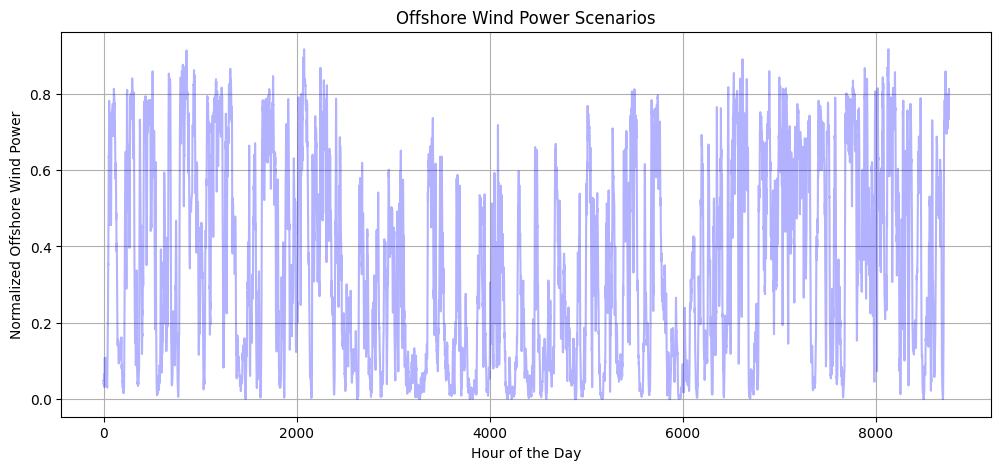

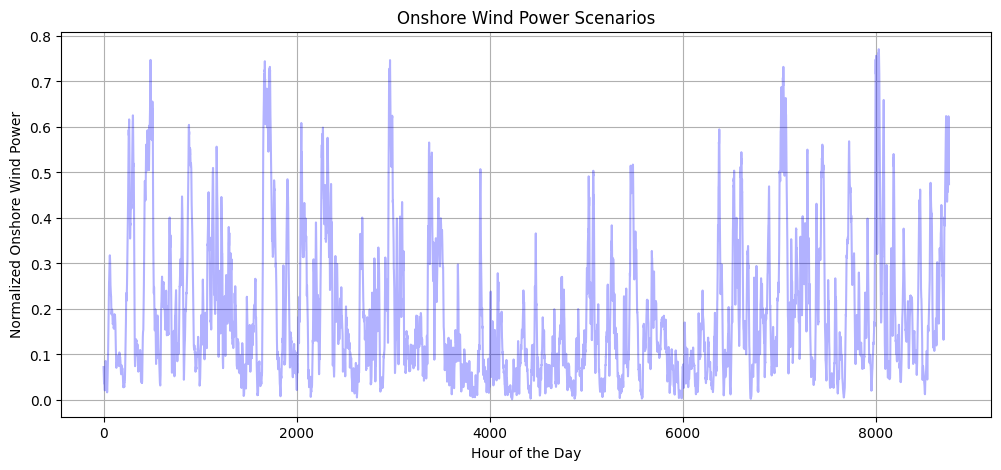

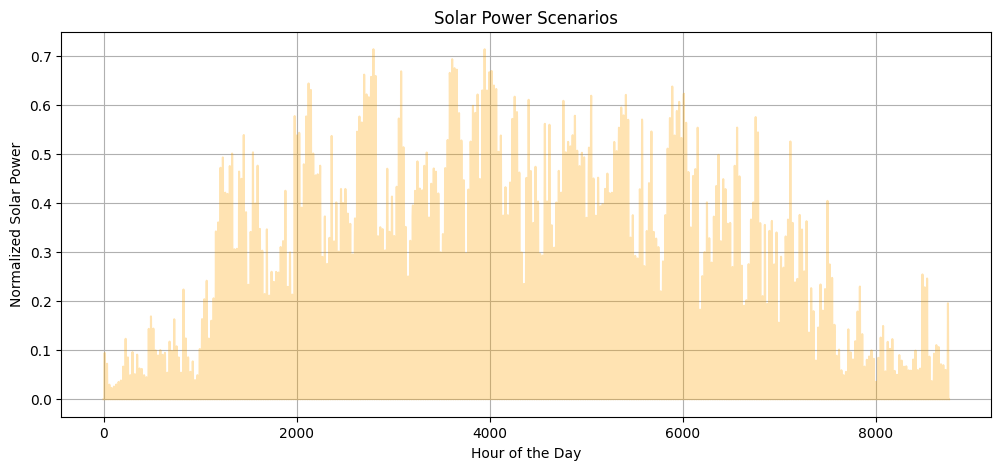

In [58]:


# Plot offshore Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen): 
    plt.plot(range(N_Hours), Offwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Offshore Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Offshore Wind Power")
plt.grid(True)
plt.show()

# Plot onshore Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  
    plt.plot(range(N_Hours), Onwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Onshore Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Onshore Wind Power")
plt.grid(True)
plt.show()

# Plot Solar Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen): 
    plt.plot(range(N_Hours), Solar_scenarios[:, scenario], alpha=0.3, color='orange')
plt.title("Solar Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Solar Power")
plt.grid(True)
plt.show()

### Plotting Capacity Factors for one day for better visibility

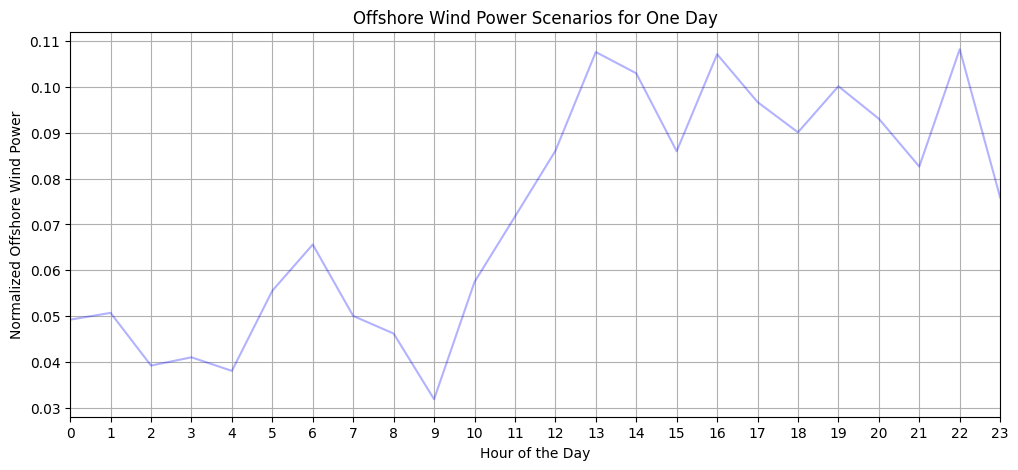

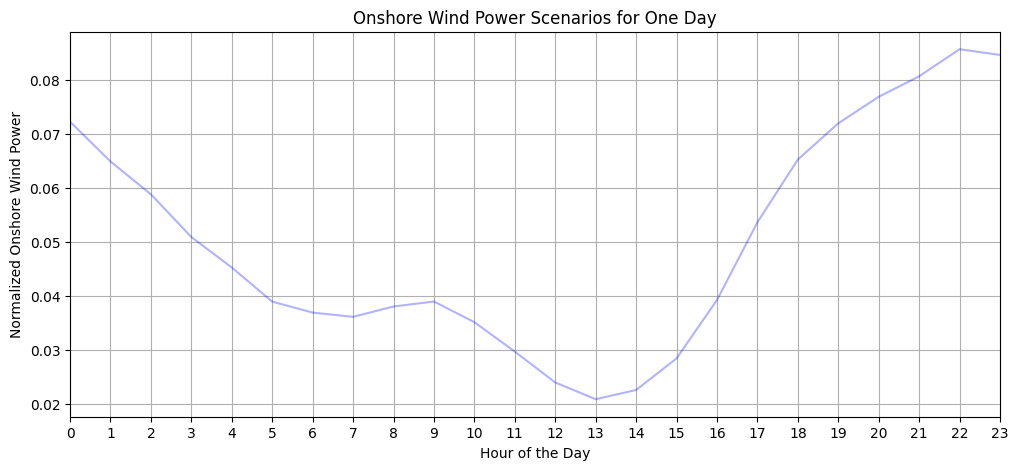

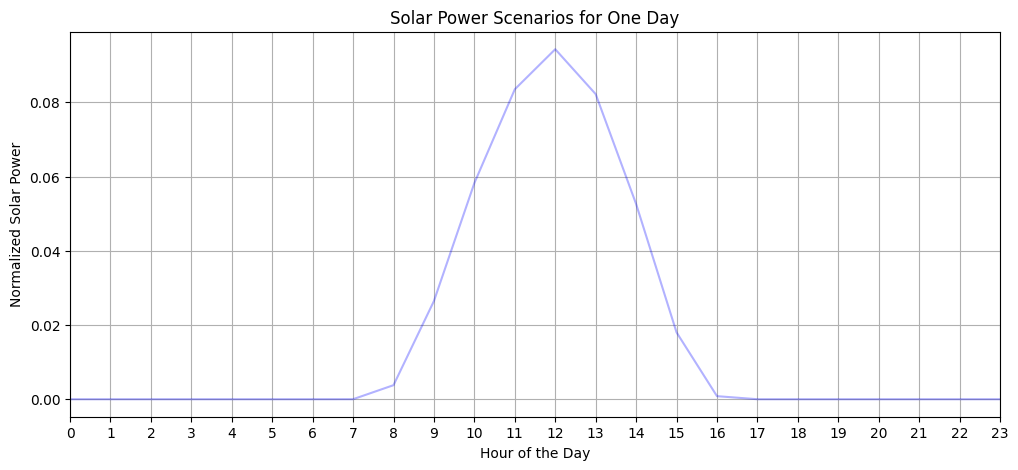

In [59]:
#Plot one day of offshore wind scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(24), Offwind_scenarios[0:24, scenario], alpha=0.3, color='blue')
plt.title("Offshore Wind Power Scenarios for One Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Offshore Wind Power")
plt.grid(True)
plt.xlim(0, 23)  # Limit x-axis to 24 hours
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.show()


#Plot one day of onshore wind scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(24), Onwind_scenarios[0:24, scenario], alpha=0.3, color='blue')
plt.title("Onshore Wind Power Scenarios for One Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Onshore Wind Power")
plt.grid(True)
plt.xlim(0, 23)  # Limit x-axis to 24 hours
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.show()

#Plot one day of solar wind scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(24), Solar_scenarios[0:24, scenario], alpha=0.3, color='blue')
plt.title("Solar Power Scenarios for One Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Solar Power")
plt.grid(True)
plt.xlim(0, 23)  # Limit x-axis to 24 hours
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.show()

### Create plot for generation and demand for defined time horizon

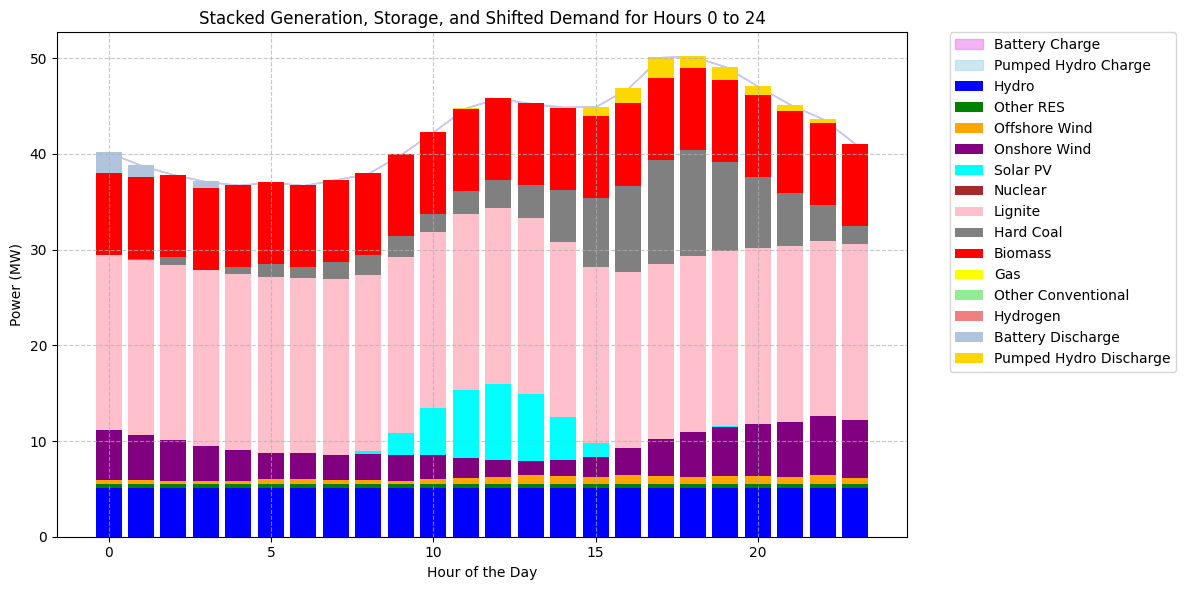

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Select the hours to be plotted
start_hour = 0
end_hour = 24
one_day_data = DayAheadProblem.res.DA_EGen_Scenarios['DA_Scenario_0'].query(f"Hour >= {start_hour} & Hour < {end_hour}")

# Prepare the data
hours = one_day_data['Hour']

# Generation and discharge sources
generation_sources = {
    'Hydro': one_day_data['Hydro'],
    'Other RES': one_day_data['Other RES'],
    'Offshore Wind': one_day_data['Offshore'],
    'Onshore Wind': one_day_data['Onshore'],
    'Solar PV': one_day_data['Solar PV'],
    'Nuclear': one_day_data['Nuclear'],
    'Lignite': one_day_data['Lignite'],
    'Hard Coal': one_day_data['Hard Coal'],
    'Biomass': one_day_data['Biomass'],
    'Gas': one_day_data['Gas'],
    'Other Conventional': one_day_data['Other Conventional'],
    'Hydrogen': one_day_data['Hydrogren'],
    'Battery Discharge': one_day_data['Battery_Discharge'],
    'Pumped Hydro Discharge': one_day_data['PumpedHydro_Discharge']
}

# Colors for generation types
gen_colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'brown', 'pink', 
              'gray', 'red', 'yellow', 'lightgreen', 'lightcoral', 'lightsteelblue', 'gold']



plt.figure(figsize=(12, 6))

# Check if there is any battery or hydro charge
if (one_day_data['Battery_Charge'].sum() == 0) and (one_day_data['PumpedHydro_Charge'].sum() == 0):
    # If there is no charge, show the original demand line
    plt.plot(one_day_data['Hour'], one_day_data['Demand'], label='Demand', color='red', linestyle='--')
else:
    # If there is charging, the demand line is hidden (visually replaced by stacked charge)
    plt.fill_between(one_day_data['Hour'],
                     one_day_data['Demand'],
                     one_day_data['Demand'] + one_day_data['Battery_Charge'],
                     label='Battery Charge', color='violet', alpha=0.6)

    plt.fill_between(one_day_data['Hour'],
                     one_day_data['Demand'] + one_day_data['Battery_Charge'],
                     one_day_data['Demand'] + one_day_data['Battery_Charge'] + one_day_data['PumpedHydro_Charge'],
                     label='Pumped Hydro Charge', color='lightblue', alpha=0.6)

# Plot the generation sources as a stacked bar chart
bottom_stack = np.zeros(len(hours))

for idx, (label, data) in enumerate(generation_sources.items()):
    plt.bar(hours, data, bottom=bottom_stack, label=label, color=gen_colors[idx])
    bottom_stack += data  # Update the bottom for the next layer

# Final touches
plt.title(f"Stacked Generation, Storage, and Shifted Demand for Hours {start_hour} to {end_hour}")
plt.xlabel("Hour of the Day")
plt.ylabel("Power (MW)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Create Plot for DA prices for defined time horizon

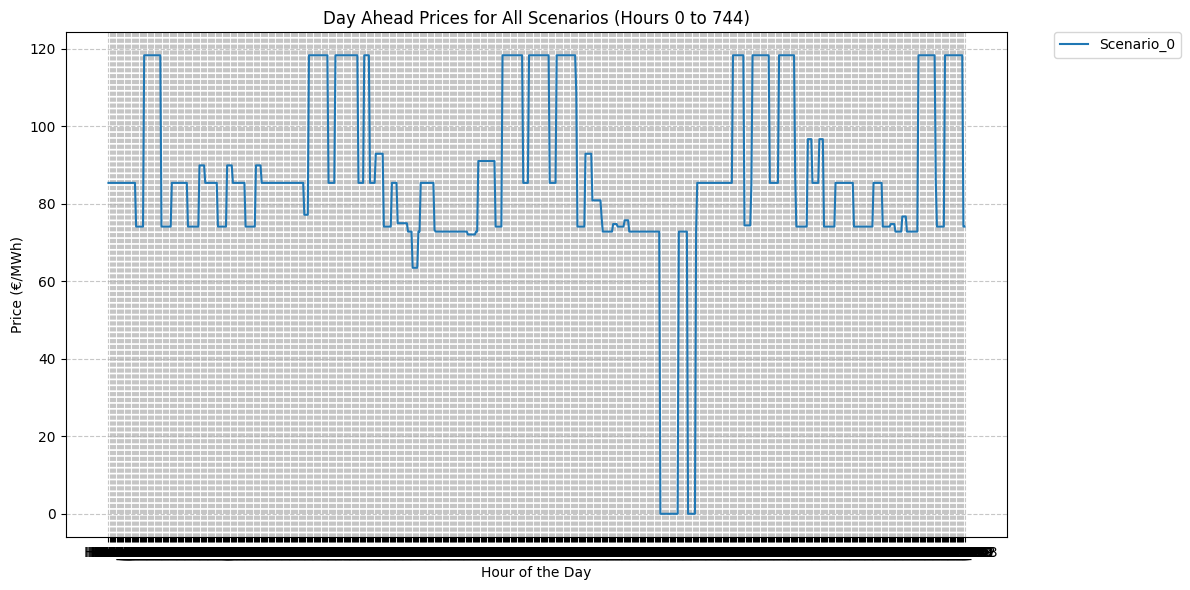

In [61]:
import matplotlib.pyplot as plt

# Choose the hour range to plot
start_hour = 0
end_hour = 24*31

# Extract the Day Ahead Prices DataFrame
prices_data = DayAheadProblem.res.DA_Prices.iloc[start_hour:end_hour]

# Plot settings
plt.figure(figsize=(12, 6))

# Plot each scenario with a different color
for scenario in prices_data.columns:
    plt.plot(prices_data.index, prices_data[scenario], label=scenario)

# Plot formatting
plt.title(f"Day Ahead Prices for All Scenarios (Hours {start_hour} to {end_hour})")
plt.xlabel("Hour of the Day")
plt.ylabel("Price (€/MWh)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Defining the Day Ahead Problem class

class BatteryOptimization():
    def __init__(self, ParametersObj, DataObj, DayAheadPrices, Model_results = 1, Guroby_results = 1):
        self.P = ParametersObj # Parameters
        self.D = DataObj # Data
        self.Model_results = int(np.array(Model_results).flatten()[0])
        self.Guroby_results = Guroby_results
        self.DAPrices = DayAheadPrices
        self.var = Expando()  # Variables
        self.con = Expando()  # Constraints
        self.res = Expando()  # Results
        self._build_model() 


    def _build_variables(self):
        # Create the variables
        self.var.DC = self.m.addMVar((self.P.N_Hours, self.P.N_Scen), lb=0)
        self.var.C = self.m.addMVar((self.P.N_Hours, self.P.N_Scen), lb=0)
        self.var.SOC = self.m.addMVar((self.P.N_Hours, self.P.N_Scen), lb=0)

    def _build_constraints(self):

        # Define SOC

        for h in range(self.P.N_Hours):
            for s in range(self.P.N_Scen):
                if h == 0:
                    self.con.SOC = self.m.addConstr(self.var.SOC[h, s] == 0, name=f"Initial_SOC_{h}_{s}")
                else:
                    self.con.SOC = self.m.addConstr(self.var.SOC[h, s] == self.var.SOC[h-1, s] + self.var.C[h-1, s]*0.9 - self.var.DC[h-1, s], name=f"SOC_{h}_{s}")

        
        for h in range(self.P.N_Hours):
            for s in range(self.P.N_Scen):

                # Limit SOC by capacity
                self.con.SOC = self.m.addConstr(self.var.SOC[h, s] <= self.P.Capacity, name=f"SOCLimit_{h}_{s}")

                # Limit charging and discharging by power
                self.con.ChargePower = self.m.addConstr(self.var.C[h, s] <= self.P.Power, name=f"PowerChargeLimite_{h}_{s}")
                self.con.DischargePower = self.m.addConstr(self.var.DC[h, s] <= self.P.Power, name=f"PowerDischargeLimit_{h}_{s}")

                # Limit charging by available capacity
                self.con.ChargeCapacity = self.m.addConstr(self.var.C[h, s]*0.9<= self.P.Capacity - self.var.SOC[h, s], name=f"ChargeLimit_{h}_{s}")

                #Limit discharging by SOC
                self.con.DischargeSOC = self.m.addConstr(self.var.DC[h, s] <= self.var.SOC[h, s], name=f"DischargeLimit_{h}_{s}")



        
    
    def _build_objective(self):

        # Battery Revenue
        Revenue = gp.quicksum(self.var.DC[h, s] * 0.9 * self.DAPrices[h, s] for h in range(self.P.N_Hours) for s in range(self.P.N_Scen))

        # Battery Costs
        Op_cost = gp.quicksum(self.var.C[h, s] * self.DAPrices[h, s] for h in range(self.P.N_Hours) for s in range(self.P.N_Scen))

        # Set objective, minimizing total costs
        self.m.setObjective((Revenue - Op_cost)/self.P.N_Scen, GRB.MAXIMIZE)


    def _display_guropby_results(self):
        self.m.setParam('OutputFlag', self.Guroby_results)

    
    def _build_model(self):
        self.m = gp.Model('CapacityProblem')
        self._build_variables()
        self._build_constraints()
        self._build_objective()
        self._display_guropby_results()
        self.m.write("CapacityProblem.lp")
        self.m.optimize()
        self._results()
        if self.Model_results == 1:
            self._extract_results()
            
   

    
    def _results(self):
        self.res.obj = self.m.objVal
        self.res.DC = self.var.DC.X
        self.res.C = self.var.C.X
        self.res.SOC = self.var.SOC.X

        #Save results in a DataFrame
        # Initialize a dictionary to store each scenario's DataFrame
        self.res.OptimizationResults = {}

        # Loop through each scenario and create a DataFrame
        for s in range(self.P.N_Scen):
            # Create DataFrames for discharge, charge, and SOC
            df_discharge = pd.DataFrame(self.res.DC[:, s], columns=['Discharge'])
            df_charge = pd.DataFrame(self.res.C[:, s], columns=['Charge'])
            df_soc = pd.DataFrame(self.res.SOC[:, s], columns=['SOC'])
            df_prices = pd.DataFrame(self.DAPrices[:, s], columns=['DA_Prices'])

            # Merge them into one DataFrame for the scenario
            df_scenario = pd.concat([df_discharge, df_charge, df_soc, df_prices], axis=1)

            # Store it in the dictionary with a descriptive name
            self.res.OptimizationResults[f"Scenario_{s}"] = df_scenario
        #Caclculate profit for each scenario and save in a dataframe
        
        

        
        
    
    
        
        

        # # Extract results
        # self.res.EGen = self.var.EGen.X
        # self.res.SOC = self.var.SOC.X
        # self.res.EChar = self.var.EChar.X
        # self.res.EDis = self.var.EDis.X



       

    def _extract_results(self):
        # Display the objective value
        print('Objective value: ', self.m.objVal)
        print('SOC', self.var.SOC.X)
        
       

In [63]:
BatteryOptimization = BatteryOptimization(ParametersObj, DataObj, DayAheadPricesTransformed, ResultsStorage)
#OptimizationResults = BatteryOptimization.res.OptimizationResults

for scenario_name, df in BatteryOptimization.res.OptimizationResults.items():
    df.to_csv(f"Battery{scenario_name}.csv", index=False)  # Save each scenario as a CSV file
    print(f"Saved {scenario_name}.csv")



Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 52560 rows, 26280 columns and 96357 nonzeros
Model fingerprint: 0xe48e2d35
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+02]
Presolve removed 33296 rows and 7016 columns
Presolve time: 0.10s
Presolved: 19264 rows, 19265 columns, 84056 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 1.156e+05
 Factor NZ  : 1.455e+05 (roughly 17 MB of memory)
 Factor Ops : 1.409e+06 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual      